# Image classification example (Cats-n-Dogs)
The open-source application “Cats-n-dogs” (link) will with some level of certainty take a guess as to whether an uploaded picture is a “Cat” or “Dog”. It’s quite basic with a rudimentary binary classification, and incorrectly predicts “Dog” when presented a picture of a cake (though probably influenced by training data pictures of dogs enjoying apple pies).

In this module we'll build a simple Convolutional Neural Network (CNN) image classifier for dogs and cats. The following stages will be completed:
- Install Required Libraries 
- Data Import
- Data Analysis
- Model Architecture
- Model Training
- Test Predictions
- Model performance

This example is closely based on https://www.kaggle.com/bavalpreet26/cnn-tutorial-keras-nb2. 

## Install Required Libraries

Import all the various libraries we'll be using in this module

In [101]:
%pip install --user scikit-learn
%pip install --user pillow

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


After installing python dependencies, make sure to restart the Kernel:
* From the menu: Kernel -> Restart

And then proceed with importing the libraries:

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


## Data Import

In [5]:
import urllib.request
url = 'https://s3.amazonaws.com/ml-experiments.spectrocloud.com/cats-n-dogs/cats-n-dogs-dataset.tar.gz'
filename = 'dataset.tar.gz'

extract_path = 'dataset'

print("Begin downloading dataset, this may take some time...")
urllib.request.urlretrieve(url, filename)
print("Dataset downloaded, beginning extraction...")
shutil.unpack_archive(filename, extract_path)
print("Done!")



Begin downloading dataset, this may take some time...
Dataset downloaded, beginning extraction...
Done!


## Data Analysis

- Let's spot check a few of the images
- Create a image generator which returns a batch of 10 images to the model

Let's start by plotting out the cats and dogs!

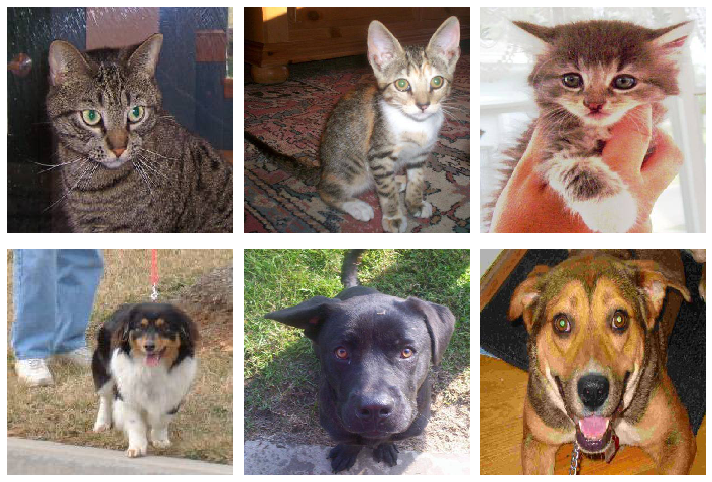

In [73]:
train_path = extract_path + '/training_set'
test_path = extract_path + '/test_set'

fig, axs = plt.subplots(2,3, figsize=(10,7))
axs = axs.flatten()

# fig.suptitle("Cats and Dogs")
cats = ["/cats/cat.%s.jpg" % n for n in [1,7,100]]
dogs = ["/dogs/dog.%s.jpg" % n for n in [2,8,99]]

for img, ax in zip(cats + dogs, axs):
    img = load_img("%s/%s" % (train_path, img), target_size=(224, 224))
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()


### Prepare images

Images used in deep-learning frameworks are generally preprocessed by centering the pixel values for each color channel. More information can be found by looking up the `tf.keras.applications.vgg16.preprocess_input` function.

An image generator can be used to return images of cats and dogs in batches of 10, along with their label. Cats are one-hot encoded as `(1,0)` where-as dogs will be `(0,1)`. The image generator also accepts a `preprocessing_function` to run the image preprocess step for each batch of images returned.

In [49]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Model Architecture

We'll build a simple convolution neural network model using Keras

In [50]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

The first layer in the model is a 2-dimensional convolutional layer. This layer will have 32 output filters each with a kernel size of 3x3, and we’ll use the relu activation function.

Note that the choice for the number of output filters specified is arbitrary, and the chosen kernel size of 3x3 is generally a very common size to use. You can experiment by choosing different values for these parameters.

We enable zero-padding by specifying padding = 'same'.

On the first layer only, we also specify the input_shape, which is the shape of our data. Our images are 224 pixels high and 224 pixels wide and have 3 color channels: RGB. This gives us an input_shape of (224,224,3).

We then add a max pooling layer to pool and reduce the dimensionality of the data.

We follow this by adding another convolutional layer with the exact specs as the earlier one, except for this second Conv2D layer has 64 filters. The choice of 64 here is again arbitrary, but the general choice of having more filters in later layers than in earlier ones is common. This layer is again followed by the same type of MaxPool2D layer

We then Flatten the output from the convolutional layer and pass it to a Dense layer. This Dense layer is the output layer of the network, and so it has 2 nodes, one for cat and one for dog. We’ll use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

We can check out a summary of the model by calling model.summary().

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we’ll look at accuracy as our performance metric.

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training

Now it’s time to train the model.

We've already introduced the model.fit() function to train a model in above cells. We'll be using it in the same fashion here, except for now, we'll be passing in our newly introduced DirectoryIterators train_batchesto train the model.

In [53]:
model.fit(x=train_batches, epochs=5, verbose=2)

  ...
    to  
  ['...']
Train for 800 steps
Epoch 1/5
800/800 - 31s - loss: 6.4018 - accuracy: 0.6130
Epoch 2/5
800/800 - 31s - loss: 0.4268 - accuracy: 0.8117
Epoch 3/5
800/800 - 31s - loss: 0.1659 - accuracy: 0.9419
Epoch 4/5
800/800 - 31s - loss: 0.0709 - accuracy: 0.9824
Epoch 5/5
800/800 - 31s - loss: 0.0450 - accuracy: 0.9898


We’re specifying 5 as the number of epochs we’d like to run, and setting the verbose parameter to 2, which just specifies the verbosity of the log output printed to the console during training.

From this output, we can see the performance of this simple model on the training set is great, with accuracy reaching almost 100% and loss nearing almost 0,we can see that our model is vastly overfitting the training data.

At this point, we could continue to work on this model to combat overfitting, or we could try another approach of using a pre-trained model on this data. We'll explore the latter in the upcoming cells.

## Test Predictions

In [56]:
predictions = model.predict(x=test_batches, verbose=0)
# predictions = model.predict(x=train_batches, verbose=0)

Spot check a few images and predictions:

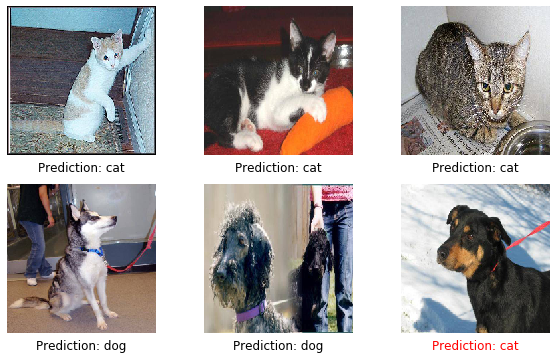

In [70]:
fig, axs = plt.subplots(2,3, figsize=(10,6))
axs = axs.flatten()

y_classifier = test_batches.classes
y_pred=np.argmax(predictions, axis=-1)

# fig.suptitle("Cats and Dogs")
cats = [["/cats/cat.%s.jpg" % (n+1+4000), n] for n in [0,500,999]]
dogs = [["/dogs/dog.%s.jpg" % (n+1+4000-1000), n] for n in [1000,1500,1999]]

for (img, index), ax in zip(cats+dogs, axs):
    img = load_img("%s/%s" % (test_path, img), target_size=(224, 224))
    ax.imshow(img)
    yp = y_pred[index]
    y = y_classifier[index]
    ax.set_title("Prediction: %s" % ["cat", "dog"][yp], y=-.15, color="black" if yp == y else "red")
    ax.axis('off')


There may be a few incorrect predictions. Let's plot how well the model performs by analyzing the total number of correctly predicted versus not.

## Analyze Model Performance

In [71]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [72]:
cm

array([[766, 234],
       [345, 655]])

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


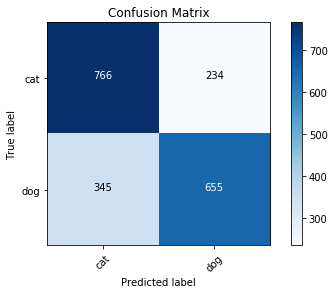

In [100]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, normalize=False, classes=cm_plot_labels, title='Confusion Matrix')